In [1]:
# Add all your imports here

import os
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib as mpl
import matplotlib.pyplot as plt
from string import punctuation
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from wordcloud import WordCloud

%matplotlib inline


In [2]:
nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/siddiqui/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/siddiqui/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
project_path = os.getcwd() + '/'

DATA_PATH = 'data/'
browser_data_path = DATA_PATH
pycharm_data_path = project_path + DATA_PATH

selected_data_path = browser_data_path
# selected_data_path = pycharm_data_path

kaggle_data_path = selected_data_path + 'kaggle_spam.csv'
dit_data_path = selected_data_path + 'dit_spam.xml'


In [4]:
kaggle_data = pd.read_csv(kaggle_data_path, encoding='latin-1')

kaggle_data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
# Converts XML to DF

def xml2df(xml_data):
    root = ET.XML(xml_data) # element tree
    all_records = []
    for i, child in enumerate(root):
        record = {}
        for subchild in child:
            record[subchild.tag] = subchild.text
            all_records.append(record)
    return pd.DataFrame(all_records)

In [6]:
dit_data_xml = open(dit_data_path).read()

dit_data = xml2df(dit_data_xml)

dit_data.head()

,class,date,number,source,text
0,spam,NaN,NaN,almeida,Free entry in 2 a wkly comp to win FA Cup fina...
1,spam,NaN,NaN,almeida,Free entry in 2 a wkly comp to win FA Cup fina...
2,spam,NaN,NaN,almeida,Free entry in 2 a wkly comp to win FA Cup fina...
3,spam,NaN,NaN,almeida,FreeMsg Hey there darling it's been 3 week's n...
4,spam,NaN,NaN,almeida,FreeMsg Hey there darling it's been 3 week's n...


In [7]:
kaggle_cleansed_data = kaggle_data.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)
kaggle_cleansed_data = kaggle_cleansed_data.rename(columns={'v1': 'class', 'v2': 'message'})


dit_cleansed_data = dit_data.drop(['date', 'number', 'source'], axis=1)
dit_cleansed_data = dit_cleansed_data.rename(columns={'text': 'message'})

In [8]:
kaggle_cleansed_data.head()

,class,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
dit_cleansed_data.head()

,class,message
0,spam,Free entry in 2 a wkly comp to win FA Cup fina...
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,spam,FreeMsg Hey there darling it's been 3 week's n...
4,spam,FreeMsg Hey there darling it's been 3 week's n...


In [10]:
combined_norm_data = pd.concat([kaggle_cleansed_data, dit_cleansed_data], ignore_index=True)

combined_norm_data.head()

,class,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [11]:
combined_norm_data.groupby('class').describe()

message                                                               
        count unique                                                top freq
class                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam     5954   1590  Camera - You are awarded a SiPix Digital Camer...    6

In [12]:
combined_norm_data['length'] = combined_norm_data['message'].apply(len)
combined_norm_data.head()

,class,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fca71540390>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fca6e1cb990>], dtype=object)

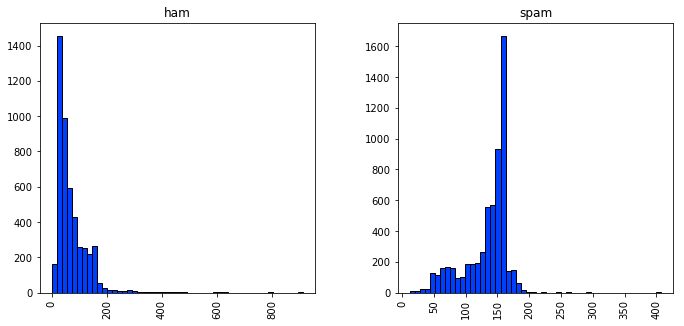

In [13]:
mpl.rcParams['patch.force_edgecolor'] = True
plt.style.use('seaborn-bright')
combined_norm_data.hist(column='length', by='class', bins=50,figsize=(11,5))


In [14]:
message_df = combined_norm_data.copy().drop(['length'], axis=1)

message_df.head()


,class,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [15]:
def strip_punctuation(s):
    return ''.join(c for c in s if c not in punctuation)


In [16]:
def process_text(text):
    
    text = strip_punctuation(text)
    text = [word for word in text.split() if word.lower() not in nltk.corpus.stopwords.words('english')]
    
    return " ".join(text)

In [17]:
message_df['message'] = message_df['message'].apply(process_text)

message_df.head()

,class,message
0,ham,Go jurong point crazy Available bugis n great ...
1,ham,Ok lar Joking wif u oni
2,spam,Free entry 2 wkly comp win FA Cup final tkts 2...
3,ham,U dun say early hor U c already say
4,ham,Nah dont think goes usf lives around though


In [18]:
spam_df = message_df[message_df['class'] == 'spam']
ham_df = message_df[message_df['class'] == 'ham']

In [19]:
ham_words = ''
spam_words = ''

for val in spam_df['message']:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        spam_words = spam_words + words + ' '
        
for val in ham_df['message']:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        ham_words = ham_words + words + ' '

In [20]:
# Generate a word cloud image
spam_wordcloud = WordCloud(width=600, height=400).generate(spam_words)
ham_wordcloud = WordCloud(width=600, height=400).generate(ham_words)

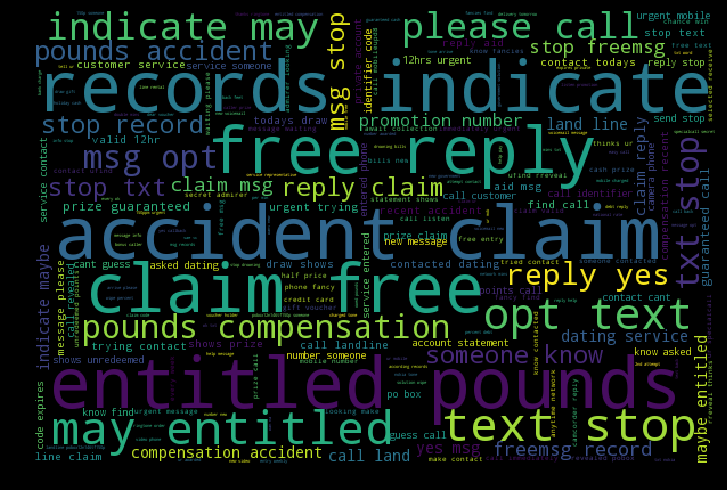

In [21]:
#Spam Word cloud

plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(spam_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

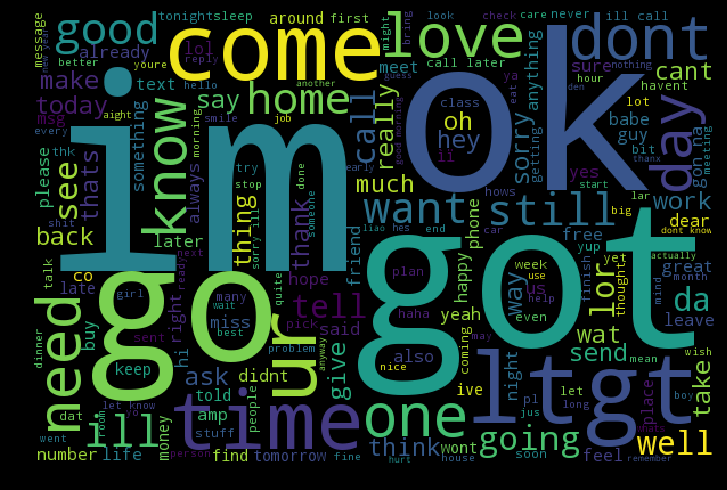

In [22]:
#Ham word cloud

plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(ham_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()